In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.layers import RepeatVector, TimeDistributed, Flatten, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM, SpatialDropout1D
import tensorflow
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras import Model
#!pip install keras_tuner
import keras_tuner
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [ ]:
imdbData = pd.read_csv('../content/IMDB Dataset.csv', encoding='utf8', engine='python', error_bad_lines=False)
imdbData.describe()

<ipython-input-31-a2cf7e5a6a73>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  imdbData = pd.read_csv('../content/IMDB Dataset.csv', encoding='utf8', engine='python', error_bad_lines=False)


,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
imdbData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
imdbData.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
imdbData.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [ ]:
df = pd.get_dummies(imdbData.sentiment)
imdbData_OneHotEncoded = pd.concat((imdbData, df), axis=1).drop(['negative', 'sentiment'], axis=1).rename(columns={'positive':'sentiment'})
imdbData_OneHotEncoded.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
5,"Probably my all-time favorite movie, a story o...",1
6,I sure would like to see a resurrection of a u...,1
7,"This show was an amazing, fresh & innovative i...",0
8,Encouraged by the positive comments about this...,0
9,If you like original gut wrenching laughter yo...,1


In [ ]:
text, label = imdbData_OneHotEncoded.review.to_numpy(), imdbData_OneHotEncoded.sentiment.to_numpy()

In [ ]:
text[0:3]

array(["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to

In [ ]:
#Train/Test Split
x_train, x_test, y_train, y_test = train_test_split(text, label, test_size=0.25, random_state=42)

In [ ]:
#Training Set
print('Training Set Size:', x_train.shape, y_train.shape)
#Test Set
print('Test Set Size:', x_test.shape, y_test.shape)

Training Set Size: (37500,) (37500,)
Test Set Size: (12500,) (12500,)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
vocabSize = 5000
tokenizer = Tokenizer(num_words=vocabSize, oov_token=None)
tokenizer.fit_on_texts(x_train)
print('Document Size:', tokenizer.document_count)
print('Word Size:', tokenizer.num_words)

Document Size: 37500
Word Size: 5000


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

seq_len = 200
def preProcessing (text_arr):
    sequence = tokenizer.texts_to_sequences(text_arr)
    padded = pad_sequences(sequence, maxlen=seq_len, padding='post', truncating='post')
    return sequence, padded

train_sequence, train_padded = preProcessing(x_train)
test_sequence, test_padded = preProcessing(x_test)

In [ ]:
tensorflow.keras.backend.clear_session()
batch = 128
embDim = 64
LSTMDim = 128
model_LSTM = Sequential()
model_LSTM.add(Embedding(input_dim = vocabSize, output_dim = embDim, input_length = seq_len))
model_LSTM.add(SpatialDropout1D(0.8))
model_LSTM.add(LSTM(LSTMDim, dropout=0.5))
model_LSTM.add(Dense(1, activation='sigmoid'))
model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model_LSTM.save('../Project/model/IMDB_LSTM.h5')
model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           320000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 64)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 418,945
Trainable params: 418,945
Non-trainable params: 0
_________________________________________________________________


In [ ]:
scaler_LSTM = MinMaxScaler()
scaler_LSTM = scaler_LSTM.fit(train_padded)
train_padded_SC = scaler_LSTM.transform(train_padded)
test_padded_SC = scaler_LSTM.transform(test_padded)

In [ ]:
history = model_LSTM.fit(train_padded_SC, y_train, epochs=20, validation_split=0.15, batch_size=batch)

In [ ]:
df_metrics_LSTM = pd.DataFrame(history.history)

In [ ]:
df_metrics_LSTM


,loss,accuracy,val_loss,val_accuracy
0,0.694626,0.504031,0.693382,0.499556
1,0.700506,0.506510,0.704195,0.504178
2,0.700017,0.501929,0.691981,0.526222
3,0.696686,0.504031,0.695916,0.521244
4,0.695417,0.500329,0.693280,0.506311
5,0.694477,0.508612,0.692172,0.511289
6,0.694457,0.510588,0.698372,0.509333
7,0.690762,0.527498,0.695795,0.516622
8,0.684955,0.539984,0.697343,0.499022
9,0.680497,0.545380,0.698066,0.515200


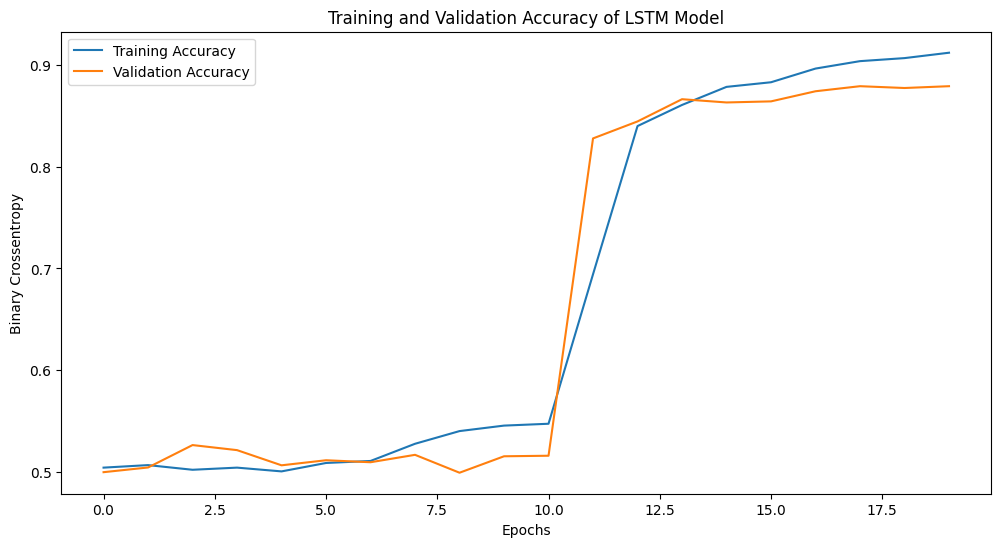

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df_metrics_LSTM.index, df_metrics_LSTM['accuracy'])
plt.plot(df_metrics_LSTM.index, df_metrics_LSTM['val_accuracy'])
plt.title('Training and Validation Accuracy of LSTM Model')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

In [ ]:
classifier_test = (model_LSTM.predict(test_padded) > 0.5).astype('int32')
errorRate_LSTM = (1 - np.round(metrics.accuracy_score(y_test, classifier_test.flatten()), 4))
print("{0: .4%}".format(errorRate_LSTM))

 12.5800%


### LSTM Autoencoder

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
scaler = MinMaxScaler()
scaler = scaler.fit(train_padded)
train_padded_SC = scaler.transform(train_padded)
test_padded_SC = scaler.transform(test_padded)

In [ ]:
def datasetGen(x, y, timesteps):
    x1, y1 = [], []
    x, y = pd.DataFrame(x), pd.DataFrame(y) 
    for i in range(len(x) - timesteps):
        x1.append(x.iloc[i:(i+timesteps)].values)
        #y1.append(y.iloc[i:(i+timesteps)].values)
        y1.append(y.iloc[i+timesteps-1])
    return np.array(x1), np.array(y1)

timesteps = 1
batch = 128
x_train_gen, y_train_gen = datasetGen(train_padded_SC, y_train, timesteps)
x_train_gen, y_train_gen = x_train_gen[:-5000], y_train_gen[:-5000]
x_test_gen, y_test_gen = datasetGen(test_padded_SC, y_test, timesteps)

#validation data
x_vali_gen, y_vali_gen = x_train_gen[-5000:], y_train_gen[-5000:]

In [ ]:
print('x_train shape:', x_train_gen.shape)
print('y_train shape:', y_train_gen.shape)
print('x_test shape:', x_test_gen.shape)
print('y_test shape:', y_test_gen.shape)
print('x_vali shape:', x_vali_gen.shape)
print('y_vali shape:', y_vali_gen.shape)

x_train shape: (20507, 1, 200)
y_train shape: (20507, 1)
x_test shape: (8502, 1, 200)
y_test shape: (8502, 1)
x_vali shape: (5000, 1, 200)
y_vali shape: (5000, 1)


In [ ]:
tensorflow.keras.backend.clear_session()

In [ ]:
import keras_tuner
hp = keras_tuner.HyperParameters()

In [ ]:

model_SA_LSTM = Sequential()
model_SA_LSTM.add(LSTM(1024, input_shape=(x_train_gen.shape[1], x_train_gen.shape[2]), return_sequences = True, activity_regularizer=L2(5e-3)))
model_SA_LSTM.add(Dropout(0.2))
model_SA_LSTM.add(LSTM(256, return_sequences = False))
model_SA_LSTM.add(Dropout(0.2))
model_SA_LSTM.add(RepeatVector(n = x_train_gen.shape[1]))
model_SA_LSTM.add(LSTM(256,return_sequences=True))
model_SA_LSTM.add(Dropout(0.2))
model_SA_LSTM.add(LSTM(512,return_sequences=True))
model_SA_LSTM.add(Dropout(0.2))
model_SA_LSTM.add(TimeDistributed(Dense(x_train_gen.shape[2])))
model_SA_LSTM.add(LSTM(256,return_sequences=False))
model_SA_LSTM.add(Dropout(0.5))
model_SA_LSTM.add(Dense(1, activation='sigmoid'))
model_SA_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_SA_LSTM.save('../Project/model/IMDB_SA_LSTM.h5')
model_SA_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 1024)           5017600   
                                                                 
 dropout (Dropout)           (None, 1, 1024)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               1311744   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 256)           0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 256)            525312    
                                                        

In [ ]:
history_SA_LSTM = model_SA_LSTM.fit(x_train_gen, y_train_gen, epochs=50,  batch_size=batch, validation_data=(x_test_gen, y_test_gen))#validation_data=(x_vali_gen, y_vali_gen))

### Hyperparameter tuning

In [ ]:
tensorflow.keras.backend.clear_session()

In [ ]:
def LSTM_AE(hp):

    hp_units1 = hp.Int('units1', min_value=128, max_value=1024, step=64)
    hp_units2 = hp.Int('units2', min_value=32, max_value=256, step=16)
    hp_units3 = hp.Int('units3', min_value=32, max_value=256, step=16)
    hp_units4 = hp.Int('units4', min_value=32, max_value=256, step=16)
    
    #hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    #hp_l2_regularizer = hp.Choice('l2', values=[L2(1e-2), L2(5e-3), L2(1e-3), L2(5e-4), L2(1e-4)])

    model_SA_LSTM = Sequential()
    model_SA_LSTM.add(LSTM(hp_units1, input_shape=(x_train_gen.shape[1], x_train_gen.shape[2]), return_sequences = True, activity_regularizer=L2(hp.Choice('reg_value', [0.01,0.001,0.1,0.005,0.05]))))
    model_SA_LSTM.add(Dropout(0.2))
    model_SA_LSTM.add(LSTM(hp_units2, return_sequences = False))
    model_SA_LSTM.add(Dropout(0.2))
    model_SA_LSTM.add(RepeatVector(n = x_train_gen.shape[1]))
    model_SA_LSTM.add(LSTM(hp_units3,return_sequences=True))
    model_SA_LSTM.add(Dropout(0.2))
    #model_SA_LSTM.add(LSTM(hp_units4,return_sequences=True))
    #model_SA_LSTM.add(Dropout(0.2))
    model_SA_LSTM.add(TimeDistributed(Dense(x_train_gen.shape[2])))
    model_SA_LSTM.add(LSTM(hp_units4,return_sequences=False))
    model_SA_LSTM.add(Dropout(0.5))
    model_SA_LSTM.add(Dense(1, activation='sigmoid'))
    model_SA_LSTM.compile(loss=BinaryCrossentropy(from_logits=False), 
                    optimizer=Adam(), 
                    metrics=[binary_accuracy])
    #model_SA_LSTM.save('../Project/model/IMDB_SA_LSTM.h5')
    #model_SA_LSTM.summary()
    return model_SA_LSTM


In [ ]:
hp = keras_tuner.HyperParameters()
LSTM_AE(hp)
tuner = keras_tuner.RandomSearch(LSTM_AE, objective = 'val_binary_accuracy', max_trials = 5, executions_per_trial = 3)
tuner.search_space_summary()

Search space summary
Default search space size: 5
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 1024, 'step': 64, 'sampling': 'linear'}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 16, 'sampling': 'linear'}
units3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 16, 'sampling': 'linear'}
units4 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 16, 'sampling': 'linear'}
reg_value (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.1, 0.005, 0.05], 'ordered': True}


In [ ]:
tuner.search(x_train_gen, y_train_gen, epochs=15, validation_data=(x_test_gen, y_test_gen))

Trial 5 Complete [00h 53m 09s]
val_binary_accuracy: 0.7184583942095438

Best val_binary_accuracy So Far: 0.7244569857915243
Total elapsed time: 04h 21m 42s


In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_binary_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
units1: 1024
units2: 128
units3: 80
units4: 64
reg_value: 0.005
Score: 0.7244569857915243

Trial 2 summary
Hyperparameters:
units1: 1024
units2: 32
units3: 256
units4: 144
reg_value: 0.01
Score: 0.7217125296592712

Trial 4 summary
Hyperparameters:
units1: 960
units2: 80
units3: 80
units4: 240
reg_value: 0.001
Score: 0.7184583942095438

Trial 3 summary
Hyperparameters:
units1: 768
units2: 256
units3: 256
units4: 256
reg_value: 0.1
Score: 0.7104602853457133

Trial 0 summary
Hyperparameters:
units1: 192
units2: 96
units3: 224
units4: 112
reg_value: 0.001
Score: 0.6944248477617899


In [ ]:
#Get the top 2 models
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.build(input_shape=(x_train_gen.shape[1], x_train_gen.shape[2]))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 1024)           5017600   
                                                                 
 dropout (Dropout)           (None, 1, 1024)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               590336    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 128)           0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 1, 80)             66880     
                                                        

In [ ]:
tensorflow.keras.backend.clear_session()
history_SA_LSTM_hyperparams = best_model.fit(x_train_gen, y_train_gen, epochs=100,  batch_size=batch, validation_data=(x_test_gen, y_test_gen))#validation_data=(x_vali_gen, y_vali_gen))

Epoch 1/100
161/161 [==============================] - 42s 249ms/step - loss: 0.1275 - binary_accuracy: 0.9446 - val_loss: 1.0114 - val_binary_accuracy: 0.7472
Epoch 2/100
161/161 [==============================] - 38s 239ms/step - loss: 0.1188 - binary_accuracy: 0.9487 - val_loss: 1.0095 - val_binary_accuracy: 0.7477
Epoch 3/100
161/161 [==============================] - 37s 233ms/step - loss: 0.1111 - binary_accuracy: 0.9511 - val_loss: 1.0692 - val_binary_accuracy: 0.7490
Epoch 4/100
161/161 [==============================] - 39s 242ms/step - loss: 0.1019 - binary_accuracy: 0.9556 - val_loss: 1.0613 - val_binary_accuracy: 0.7506
Epoch 5/100
161/161 [==============================] - 37s 231ms/step - loss: 0.0967 - binary_accuracy: 0.9565 - val_loss: 1.1537 - val_binary_accuracy: 0.7506
Epoch 6/100
161/161 [==============================] - 37s 228ms/step - loss: 0.0922 - binary_accuracy: 0.9599 - val_loss: 1.1481 - val_binary_accuracy: 0.7555
Epoch 7/100
161/161 [===================